In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fruits:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5857%2F2609027%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240523%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240523T160427Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D28d47b602a4cdb9174cf3adc71caede46df78326f51d4f10e69bd097e25222f146afe49be356f701c06beb4aa43e6dd2c8b14702ec6e38334436494cd0a61d0fede41d410b937d75f932f1dbb3b5a57c3f5231a466807bc5ada25f323ca771cecbe83b64ef3b6dddb6f3f1ad8b6bcfb69b3a395a02201e98fe1059aa2e4cd296648d3c6f73a7852d9027327f7025e89a60a9facb8fb2d5a3fffd0d71843df75659e4c3708b552d6b3300bf186a14fcc7d0353c425e8f662f88b33ead5c2c97df26a4ce73c8604adf5f5c3f79ecd03fa947b1f1dca80ac527b4879b0406f2805deaed011bd04107238dc5a3bf1be522c234cf1aa6b7a54228dbaf11e4565ce2ff'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1379678841 bytes downloaded
Downloaded and uncompressed: fruits
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import cv2


import os

In [3]:
train_path = ("/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training")
test_path = ("/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test")

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255.0,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range = 0.3,
                                   zoom_range = 0.3,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = (100, 100),
                                              batch_size = 64,
                                              class_mode = 'categorical',
                                              subset="training")

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(100,100),
                                            batch_size=64,
                                            class_mode="categorical",
                                            subset="validation")

test_set = test_datagen.flow_from_directory(test_path,
                                                 target_size = (100, 100),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [6]:
len(train_set)

847

In [7]:
len(val_set)

211

In [8]:
num_classes = len(train_set.class_indices)
print("Number of Classes:", num_classes)

labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Number of Classes: 131
{0: 'Apple Braeburn', 1: 'Apple Crimson Snow', 2: 'Apple Golden 1', 3: 'Apple Golden 2', 4: 'Apple Golden 3', 5: 'Apple Granny Smith', 6: 'Apple Pink Lady', 7: 'Apple Red 1', 8: 'Apple Red 2', 9: 'Apple Red 3', 10: 'Apple Red Delicious', 11: 'Apple Red Yellow 1', 12: 'Apple Red Yellow 2', 13: 'Apricot', 14: 'Avocado', 15: 'Avocado ripe', 16: 'Banana', 17: 'Banana Lady Finger', 18: 'Banana Red', 19: 'Beetroot', 20: 'Blueberry', 21: 'Cactus fruit', 22: 'Cantaloupe 1', 23: 'Cantaloupe 2', 24: 'Carambula', 25: 'Cauliflower', 26: 'Cherry 1', 27: 'Cherry 2', 28: 'Cherry Rainier', 29: 'Cherry Wax Black', 30: 'Cherry Wax Red', 31: 'Cherry Wax Yellow', 32: 'Chestnut', 33: 'Clementine', 34: 'Cocos', 35: 'Corn', 36: 'Corn Husk', 37: 'Cucumber Ripe', 38: 'Cucumber Ripe 2', 39: 'Dates', 40: 'Eggplant', 41: 'Fig', 42: 'Ginger Root', 43: 'Granadilla', 44: 'Grape Blue', 45: 'Grape Pink', 46: 'Grape White', 47: 'Grape White 2', 48: 'Grape White 3', 49: 'Grape White 4', 50: 'Grape

# **CNN Model**

In [9]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)

In [10]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3,3), padding="same", input_shape=(100,100,3), activation="relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_cnn.add(Dropout(0.2))


model_cnn.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_cnn.add(Dropout(0.3))


model_cnn.add(Conv2D(128, (3,3), padding="same", activation="relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_cnn.add(Dropout(0.4))


model_cnn.add(Conv2D(256, (3,3), padding="same", activation="relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_cnn.add(Dropout(0.5))


model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation="relu"))
model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(131, activation="softmax"))

model_cnn.summary()

model_cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 100, 100, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 64)        2

In [11]:
history = model_cnn.fit(train_set,
                    steps_per_epoch = 50,
                    epochs = 30,
                    validation_data = val_set,
                    validation_steps = 200)

Epoch 1/30
50/50 [==============================] - 57s 1s/step - loss: 5.8731 - accuracy: 0.0088 - val_loss: 5.7223 - val_accuracy: 0.0065
Epoch 2/30
50/50 [==============================] - 52s 1s/step - loss: 4.9293 - accuracy: 0.0119 - val_loss: 8.1064 - val_accuracy: 0.0064
Epoch 3/30
50/50 [==============================] - 52s 1s/step - loss: 4.8368 - accuracy: 0.0219 - val_loss: 9.2603 - val_accuracy: 0.0068
Epoch 4/30
50/50 [==============================] - 49s 993ms/step - loss: 4.7193 - accuracy: 0.0300 - val_loss: 10.5073 - val_accuracy: 0.0081
Epoch 5/30
50/50 [==============================] - 49s 985ms/step - loss: 4.5496 - accuracy: 0.0428 - val_loss: 11.1760 - val_accuracy: 0.0081
Epoch 6/30
50/50 [==============================] - 52s 1s/step - loss: 4.4479 - accuracy: 0.0512 - val_loss: 12.3485 - val_accuracy: 0.0048
Epoch 7/30
50/50 [==============================] - 52s 1s/step - loss: 4.2520 - accuracy: 0.0745 - val_loss: 12.2601 - val_accuracy: 0.0105
Epoch 8/30

In [12]:
print(history.history)

{'loss': [5.873052597045898, 4.92928409576416, 4.836754322052002, 4.719274997711182, 4.549627780914307, 4.447934627532959, 4.25196647644043, 4.142129421234131, 3.9921863079071045, 3.9265291690826416, 3.773695707321167, 3.707447052001953, 3.5969738960266113, 3.4773666858673096, 3.402008295059204, 3.2729406356811523, 3.1313698291778564, 3.1089677810668945, 3.005506992340088, 2.934818744659424, 2.8089759349823, 2.795856237411499, 2.735531806945801, 2.639569044113159, 2.4954357147216797, 2.50522518157959, 2.4856929779052734, 2.359560966491699, 2.3330862522125244, 2.270242214202881], 'accuracy': [0.008750000037252903, 0.011874999850988388, 0.02187499962747097, 0.029999999329447746, 0.04281250014901161, 0.051249999552965164, 0.07448145747184753, 0.0871874988079071, 0.09968750178813934, 0.10093750059604645, 0.1219358891248703, 0.13042111694812775, 0.14249999821186066, 0.15625, 0.1634192317724228, 0.18125000596046448, 0.20499999821186066, 0.20874999463558197, 0.22218750417232513, 0.23781250417

In [13]:
score = model_cnn.evaluate(test_set, batch_size=128, verbose=1)
print("\nTest result: %.3f loss: %3f" % (score[1]*100, score[0]))

355/355 [==============================] - 14s 40ms/step - loss: 10.4672 - accuracy: 0.1049

Test result: 10.486 loss: 10.467161


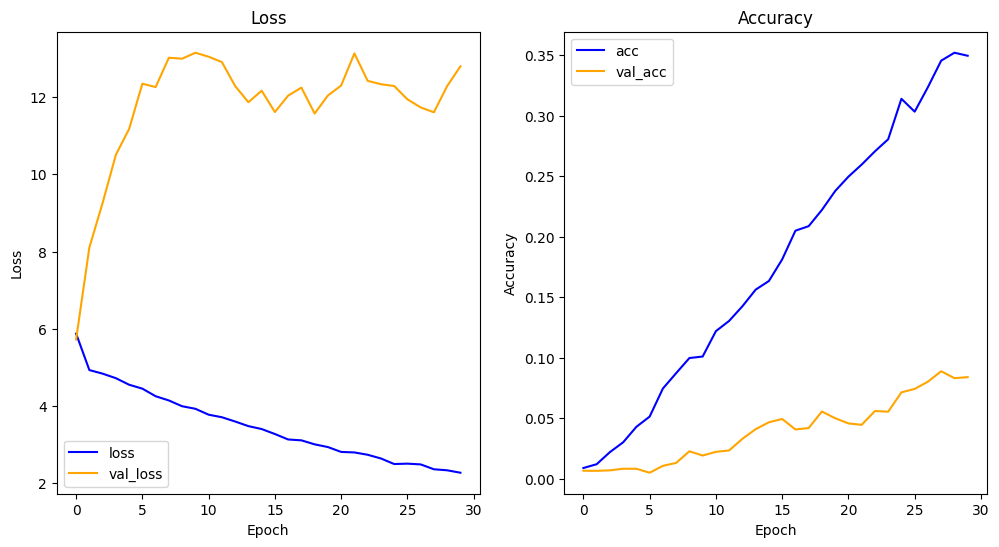

In [14]:
# Plot loss per iteration

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss', color="blue")
plt.plot(history.history['val_loss'], label='val_loss', color="orange")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy per iteration

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='acc', color="blue")
plt.plot(history.history['val_accuracy'], label='val_acc', color="orange")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

2/2 [==============================] - 0s 8ms/step


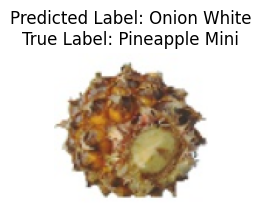

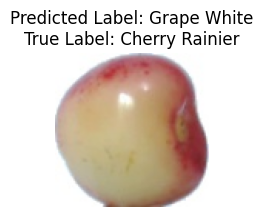

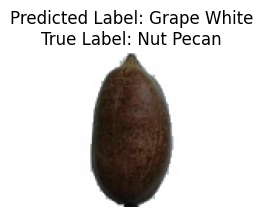

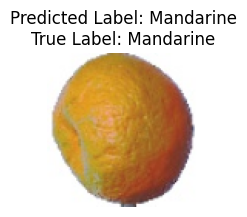

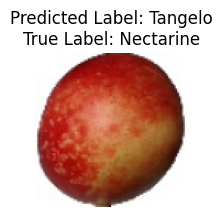

In [15]:
test_images, test_labels = next(test_set)
predictions = model_cnn.predict(test_images)

for i in range(5):
    predicted_label_index = np.argmax(predictions[i])
    predicted_label = labels[predicted_label_index]
    true_label_index = np.argmax(test_labels[i])
    true_label = labels[true_label_index]

    # Show image
    plt.figure(figsize=(2,2))
    plt.imshow(test_images[i])
    plt.title(f"Predicted Label: {predicted_label}\nTrue Label: {true_label}")
    plt.axis('off')
    plt.show()

# **VGG16 Model**

In [16]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30, width_shift_range=0.3,
                               height_shift_range=0.3, shear_range=0.,
                               zoom_range=0.3, horizontal_flip=True,
                               vertical_flip=True,
                               #brightness_range=[0.8, 1.2],
                               #channel_shift_range=50.0,
                               fill_mode='nearest',
                               validation_split=0.2)

train_vgg = train_gen.flow_from_directory(train_path,
                                     target_size = (100, 100),
                                     batch_size = 64,
                                     class_mode = 'categorical',
                                     subset="training")


val_vgg = train_gen.flow_from_directory(train_path,
                                  target_size=(100,100),
                                  batch_size=64,
                                  class_mode="categorical",
                                  subset="validation")


test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_vgg = test_gen.flow_from_directory(test_path,
                                   target_size = (100, 100),
                                   batch_size = 64,
                                   class_mode = 'categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [17]:
labels = {v: k for k, v in train_vgg.class_indices.items()}
print(labels)

{0: 'Apple Braeburn', 1: 'Apple Crimson Snow', 2: 'Apple Golden 1', 3: 'Apple Golden 2', 4: 'Apple Golden 3', 5: 'Apple Granny Smith', 6: 'Apple Pink Lady', 7: 'Apple Red 1', 8: 'Apple Red 2', 9: 'Apple Red 3', 10: 'Apple Red Delicious', 11: 'Apple Red Yellow 1', 12: 'Apple Red Yellow 2', 13: 'Apricot', 14: 'Avocado', 15: 'Avocado ripe', 16: 'Banana', 17: 'Banana Lady Finger', 18: 'Banana Red', 19: 'Beetroot', 20: 'Blueberry', 21: 'Cactus fruit', 22: 'Cantaloupe 1', 23: 'Cantaloupe 2', 24: 'Carambula', 25: 'Cauliflower', 26: 'Cherry 1', 27: 'Cherry 2', 28: 'Cherry Rainier', 29: 'Cherry Wax Black', 30: 'Cherry Wax Red', 31: 'Cherry Wax Yellow', 32: 'Chestnut', 33: 'Clementine', 34: 'Cocos', 35: 'Corn', 36: 'Corn Husk', 37: 'Cucumber Ripe', 38: 'Cucumber Ripe 2', 39: 'Dates', 40: 'Eggplant', 41: 'Fig', 42: 'Ginger Root', 43: 'Granadilla', 44: 'Grape Blue', 45: 'Grape Pink', 46: 'Grape White', 47: 'Grape White 2', 48: 'Grape White 3', 49: 'Grape White 4', 50: 'Grapefruit Pink', 51: 'Grape

In [18]:
vgg_model = VGG16(weights="imagenet" ,include_top=False, input_shape=(100,100,3))

for layer in vgg_model.layers:
    layer.trainable = True

for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.output_shape)

58889256/58889256 [==============================] - 0s 0us/step
0 input_1 [(None, 100, 100, 3)]
1 block1_conv1 (None, 100, 100, 64)
2 block1_conv2 (None, 100, 100, 64)
3 block1_pool (None, 50, 50, 64)
4 block2_conv1 (None, 50, 50, 128)
5 block2_conv2 (None, 50, 50, 128)
6 block2_pool (None, 25, 25, 128)
7 block3_conv1 (None, 25, 25, 256)
8 block3_conv2 (None, 25, 25, 256)
9 block3_conv3 (None, 25, 25, 256)
10 block3_pool (None, 12, 12, 256)
11 block4_conv1 (None, 12, 12, 512)
12 block4_conv2 (None, 12, 12, 512)
13 block4_conv3 (None, 12, 12, 512)
14 block4_pool (None, 6, 6, 512)
15 block5_conv1 (None, 6, 6, 512)
16 block5_conv2 (None, 6, 6, 512)
17 block5_conv3 (None, 6, 6, 512)
18 block5_pool (None, 3, 3, 512)


In [19]:
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(131, activation="softmax")(x)

In [20]:
vgg = Model(inputs=vgg_model.input, outputs=predictions)

In [21]:
vgg.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
vgg_history = vgg.fit(
    train_vgg,
    steps_per_epoch=train_vgg.samples // train_vgg.batch_size,
    epochs=5,
    validation_data=val_vgg,
    validation_steps=val_vgg.samples // val_vgg.batch_size)


test_loss, test_acc = vgg.evaluate(test_vgg, batch_size=128, verbose=1)
print('Test accuracy:', test_acc)

score = vgg.evaluate(test_vgg, batch_size=128, verbose=1)
print("\nTest result: %.3f loss: %3f" % (score[1]*100, score[0]))

Epoch 1/5
846/846 [==============================] - 289s 326ms/step - loss: 1.6110 - accuracy: 0.6329 - val_loss: 0.3341 - val_accuracy: 0.8975
Epoch 2/5
846/846 [==============================] - 306s 361ms/step - loss: 0.1238 - accuracy: 0.9616 - val_loss: 0.2447 - val_accuracy: 0.9324
Epoch 3/5
846/846 [==============================] - 307s 363ms/step - loss: 0.0964 - accuracy: 0.9710 - val_loss: 0.1570 - val_accuracy: 0.9564
Epoch 4/5
846/846 [==============================] - 306s 361ms/step - loss: 0.0760 - accuracy: 0.9776 - val_loss: 0.3063 - val_accuracy: 0.9239
Epoch 5/5
355/355 [==============================] - 24s 67ms/step - loss: 0.0600 - accuracy: 0.9814
Test accuracy: 0.9813998341560364
355/355 [==============================] - 22s 62ms/step - loss: 0.0600 - accuracy: 0.9814

Test result: 98.140 loss: 0.059956


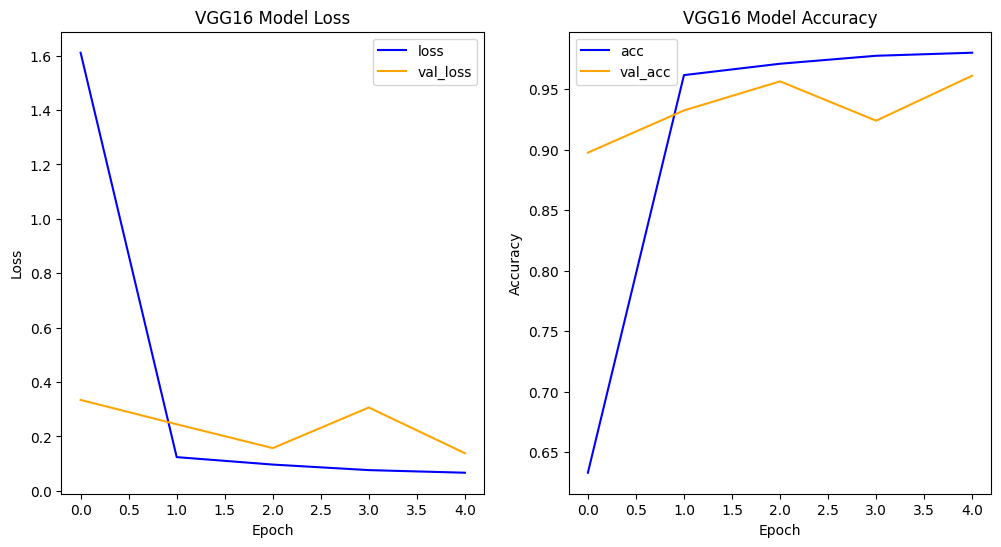

In [23]:
# Plot loss per iteration for VGG

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(vgg_history.history['loss'], label='loss', color="blue")
plt.plot(vgg_history.history['val_loss'], label='val_loss', color="orange")
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy per iteration for VGG

plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['accuracy'], label='acc', color="blue")
plt.plot(vgg_history.history['val_accuracy'], label='val_acc', color="orange")
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

2/2 [==============================] - 0s 25ms/step


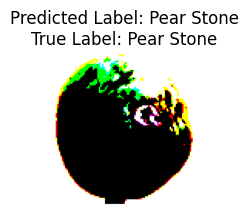

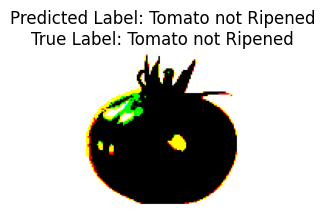

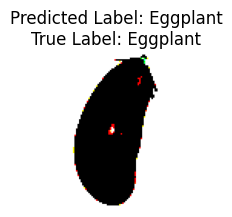

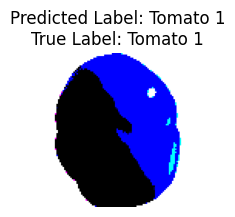

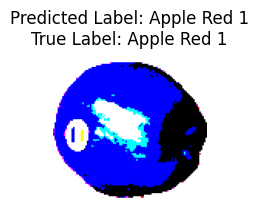

In [24]:
test_images, test_labels = next(test_vgg)
predictions = vgg.predict(test_images)

for i in range(5):
    predicted_label_index = np.argmax(predictions[i])
    predicted_label = labels[predicted_label_index]
    true_label_index = np.argmax(test_labels[i])
    true_label = labels[true_label_index]

    # Show image
    plt.figure(figsize=(2,2))
    plt.imshow(test_images[i])
    plt.title(f"Predicted Label: {predicted_label}\nTrue Label: {true_label}")
    plt.axis('off')
    plt.show()